In [ ]:
%pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 tensorflow-io matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Loading the Dataset

In [19]:
def remove_nans(data):
    spectrograms = data['x']
    spectrograms[np.isinf(spectrograms)] = np.nan

    for i in range(spectrograms.shape[0]):
        sample = spectrograms[i, :, :]

        mean_valid = np.nanmean(sample)
        sample[np.isnan(sample)] = mean_valid if mean_valid != np.inf else 0 
       
        spectrograms[i, :, :] = sample
    

    return spectrograms
    

In [20]:


real_data = np.load('../../footprints/Footprints Datasets/real.npz')
fake_data = np.load('../../footprints/Footprints Datasets/fake.npz')

print(np.sum(np.isnan(real_data['x'])))

print(np.sum(np.isnan(fake_data['x'])))

real_data = remove_nans(real_data)
fake_data = remove_nans(fake_data)

print(np.sum(np.isinf(real_data)))
print(np.sum(np.isinf(fake_data)))

print(np.sum(np.isnan(real_data)))
print(np.sum(np.isnan(fake_data)))

print(real_data.shape)


print(np.max(real_data))



0
0
0
0
0
0
(750, 1998, 101)
65470.0


## Preprcoessing the Data
- Put the Data all in one repo, with adding labels to them and preparing them in the shape of image for CNNs

In [21]:
real_dataset = tf.data.Dataset.from_tensor_slices(real_data)
fake_dataset = tf.data.Dataset.from_tensor_slices(fake_data)
real_dataset = real_dataset.map(lambda x: tf.expand_dims(x, axis=-1))
fake_dataset = fake_dataset.map(lambda x: tf.expand_dims(x, axis=-1))

real_labels = tf.data.Dataset.from_tensor_slices(tf.ones((750,), dtype=tf.int32))

fake_labels = tf.data.Dataset.from_tensor_slices(tf.zeros((750,), dtype=tf.int32))

positives = tf.data.Dataset.zip((real_dataset, real_labels))
negatives = tf.data.Dataset.zip((fake_dataset, fake_labels))

# Concatenate the datasets
combined_dataset = positives.concatenate(negatives)





## Split the data into training and testing sets

In [22]:
def preprocess_before_training(combined_dataset):
    combined_dataset = combined_dataset.cache()
    combined_dataset = combined_dataset.shuffle(buffer_size=1000)
    combined_dataset = combined_dataset.batch(16)
    combined_dataset = combined_dataset.prefetch(8)
    return combined_dataset



total_samples = 1500
train_ratio = 0.8

combined_dataset = combined_dataset.shuffle(buffer_size=1000)

train_size = int(train_ratio * total_samples)
test_size = total_samples - train_size

train_dataset = combined_dataset.take(train_size)
test_dataset = combined_dataset.skip(train_size).take(test_size)

train_dataset = preprocess_before_training(train_dataset)
test_dataset = preprocess_before_training(test_dataset)




## Plotting the Signals for Patterns

In [23]:
sample = combined_dataset.take(5)
for data, label in sample:
    spectrogram = data
    #spectrogram = tf.expand_dims(spectrogram, axis=2)
    print(data.shape)
    print(label)
    #print(label)
    # Check for NaN values in data
    #tf.debugging.check_numerics(data, "NaN or Inf values in data")
    # Check for NaN values in labels
    #tf.debugging.check_numerics(label, "NaN or Inf values in labels")

(1998, 101, 1)
tf.Tensor(0, shape=(), dtype=int32)
(1998, 101, 1)
tf.Tensor(0, shape=(), dtype=int32)
(1998, 101, 1)
tf.Tensor(1, shape=(), dtype=int32)
(1998, 101, 1)
tf.Tensor(1, shape=(), dtype=int32)
(1998, 101, 1)
tf.Tensor(1, shape=(), dtype=int32)


## OUR CNN MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1998, 101, 1) ))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
from tensorflow.keras import layers, models

model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(1998, 101, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Optional dropout for regularization
model.add(layers.Dense(1, activation='sigmoid'))

In [25]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1996, 99, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 998, 49, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 996, 47, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 498, 23, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 496, 21, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 248, 10, 128)      0         
_________________________________________________________________
flatten (Flatten)            (None, 317440)            0

In [27]:
hist = model.fit(train_dataset, epochs=4, validation_data=test_dataset)

Epoch 1/4
75/75 [==============================] - 164s 2s/step - loss: 32.5267 - recall: 0.6048 - precision: 0.6591 - val_loss: 0.5167 - val_recall: 0.8367 - val_precision: 0.7785
Epoch 2/4
75/75 [==============================] - 169s 2s/step - loss: 0.5564 - recall: 0.7565 - precision: 0.8450 - val_loss: 0.3751 - val_recall: 0.8435 - val_precision: 0.8552
Epoch 3/4
75/75 [==============================] - 169s 2s/step - loss: 0.3406 - recall: 0.8984 - precision: 0.9457 - val_loss: 0.4422 - val_recall: 0.5782 - val_precision: 0.9444
Epoch 4/4
75/75 [==============================] - 169s 2s/step - loss: 0.4279 - recall: 0.8145 - precision: 0.8647 - val_loss: 0.3670 - val_recall: 0.8231 - val_precision: 0.9680


In [28]:
print(model.predict(np.zeros((1, 1998, 101, 1))))

[[0.14020663]]


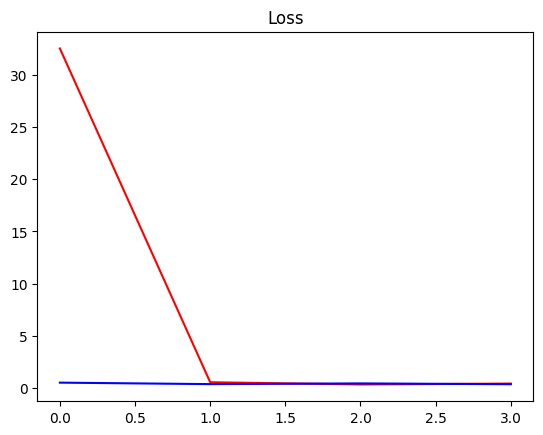

In [29]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

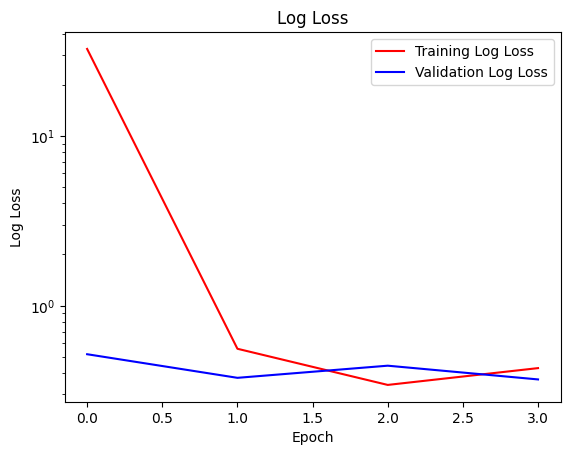

In [30]:
plt.title('Log Loss')
plt.semilogy(hist.history['loss'], 'r', label='Training Log Loss')
plt.semilogy(hist.history['val_loss'], 'b', label='Validation Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

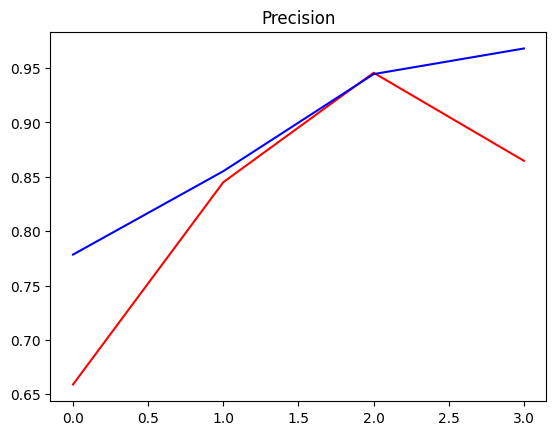

In [31]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [ ]:
from tensorflow.keras.models import save_model

In [32]:
model.save('./eagle_model')

INFO:tensorflow:Assets written to: ./eagle_model\assets


In [ ]:
pos_spec = None
for spec, label in validate_pos.take(5):
    print(model.predict(tf.reshape(np.zeros(1998, 101), (1, 1998, 101, 1))))
    print(label)

In [33]:
saved_model_path = './saved_eagle'

# Load the trained model
loaded_model = tf.keras.models.load_model('./eagle_model')

# Save the loaded model
tf.saved_model.save(loaded_model, saved_model_path)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: ./saved_eagle\assets


In [ ]:
import zipfile
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
#list of spectograms [] real fake
list = np.concatenate((real_data, fake_data), axis=0)

print(list.shape)

labels = np.concatenate((np.ones((750,)), np.zeros((750,))))


X_train, X_test, y_train, y_test = train_test_split(list, labels, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm

In [ ]:
# Create Gradient Boosting classifier
model = GradientBoostingClassifier(verbose=1, random_state=42)

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


In [ ]:

model.fit(train_dataset, y_train)